# Black Friday Data EDA and Feature Engineering

### dataset link:
https://www.kaggle.com/datasets/sdolezel/black-friday?resource=download

### Problem Statement: 
A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month. The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month. Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

## Cleaning and Preprocessing

Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from black_friday_eda.utils import load_train, load_test, check_df, concat_df_on_y_axis, grab_col_names, cat_summary, num_summary_enhanced, one_hot_encoder, RandomForestRegressor, plot_importance

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

Loading datasets

In [3]:
df_train = load_train()
df_test = load_test()

In [ ]:
check_df(df_train)

In [ ]:
check_df(df_test)

Concatenating train-test sets to preprocess as a whole and to prevent data leak.

In [4]:
df_train_test = concat_df_on_y_axis(df_train, df_test)

In [5]:
check_df(df_train_test)

##################### Shape #####################
(783667, 12)
##################### Types #####################
User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                      float64
dtype: object
##################### Head #####################
   User_ID Product_ID Gender   Age  Occupation City_Category Stay_In_Current_City_Years  Marital_Status  Product_Category_1  Product_Category_2  Product_Category_3  Purchase
0  1000001  P00069042      F  0-17          10             A                          2               0                   3                 NaN                 NaN  8370.000
1  1000001  P0024894

In [6]:
# Dropping User_ID
df_train_test.drop("User_ID", axis=1, inplace=True)

### Observations:
- Duplicates are observed both in test and train sets.
- NA values observed on Product_Category_2 and Product_Category_3 columns. NA values in these features will be filled with 0 because a product simply can have only a main category (Product_Category_1)
- Slight right skew on Product_Category_1 and Product_Category_2, slight left skew on Product_Category_3 features.

### NA Values Examination

In [ ]:
# na heatmap black and white
plt.figure(figsize=(12, 8))
sns.heatmap(df_train_test.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

In [7]:
df_train_test['Product_Category_2'] = df_train_test['Product_Category_2'].fillna(0)
df_train_test['Product_Category_3'] = df_train_test['Product_Category_3'].fillna(0)

In [8]:
# type fixing of product categories as int
df_train_test['Product_Category_2'] = df_train_test['Product_Category_2'].astype("int64")
df_train_test['Product_Category_3'] = df_train_test['Product_Category_3'].astype("int64")

In [ ]:
product_cat_1_set = set(df_train_test["Product_Category_1"].unique())
product_cat_2_set = set(df_train_test["Product_Category_2"].unique())
product_cat_3_set = set(df_train_test["Product_Category_3"].unique())

print(f"Product_Category_1 unique values: {product_cat_1_set}\n")
print(f"Product_Category_2 unique values: {product_cat_2_set}\n")
print(f"Product_Category_3 unique values: {product_cat_3_set}\n\n")

# universal set of product categories
universal_set = product_cat_1_set.union(product_cat_2_set).union(product_cat_3_set)
print(f"Universal Set: {universal_set}\n\n")

# only in product_cat_1_set
only_in_1 = product_cat_1_set - product_cat_2_set - product_cat_3_set
# only in product_cat_2_set
only_in_2 = product_cat_2_set - product_cat_1_set - product_cat_3_set
# only in product_cat_3_set
only_in_3 = product_cat_3_set - product_cat_1_set - product_cat_2_set

print(f"Only in Product_Category_1: {only_in_1}\n")
print(f"Only in Product_Category_2: {only_in_2}\n")
print(f"Only in Product_Category_3: {only_in_3}\n\n")

# product_cat_1_set/product_cat_2_set
difference_1_2 = product_cat_1_set - product_cat_2_set
# product_cat_1_set/product_cat_3_set
difference_1_3 = product_cat_1_set - product_cat_3_set
# product_cat_3_set/product_cat_2_set
difference_3_2 = product_cat_3_set - product_cat_2_set
# product_cat_2_set/product_cat_3_set
difference_2_3 = product_cat_2_set - product_cat_3_set

print(f"Product_Category_1 - Product_Category_2: {difference_1_2}")
print(f"Product_Category_1 - Product_Category_3: {difference_1_3}")
print(f"Product_Category_3 - Product_Category_2: {difference_3_2}")
print(f"Product_Category_2 - Product_Category_3: {difference_2_3}")

### Feature Examinations
In this section features will be examined according to their numeric or categorical natures.

#### Identifying Categorical and Numerical Features
Using grab_col_names() function, we can achieve a seperation by defining some rules. Parameters used to define seperation rule in this function is as follows:
- cat_th (int): Threshold for numerical columns to be considered categorical. Defined: 22 => due to maximum unique value containing cat feature is Age. Occupation is an exception. 
- car_th (int): Threshold for categorical columns to be considered cardinal. Defined: 22


In [9]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train_test)
print(f"Categorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")
print(f"Categorical but Cardinal Columns: {cat_but_car}")

Observations: 783667
Variables: 11
cat_cols: 9
num_cols: 1
cat_but_car: 1
num_but_cat: 5
Categorical Columns: ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Occupation', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']
Numerical Columns: ['Purchase']
Categorical but Cardinal Columns: ['Product_ID']


#### Categorical Columns Visualization

In [105]:
# countplot and pieplot comparison of categorical variables of train and test sets side by side
def plot_categorical_comparison(df_train, df_test, cat_cols):
    for col in cat_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        sns.countplot(x=col, data=df_train, ax=axes[0])
        axes[0].set_title(f"Train Set: {col}")
        sns.countplot(x=col, data=df_test, ax=axes[1])
        axes[1].set_title(f"Test Set: {col}")
        plt.show()


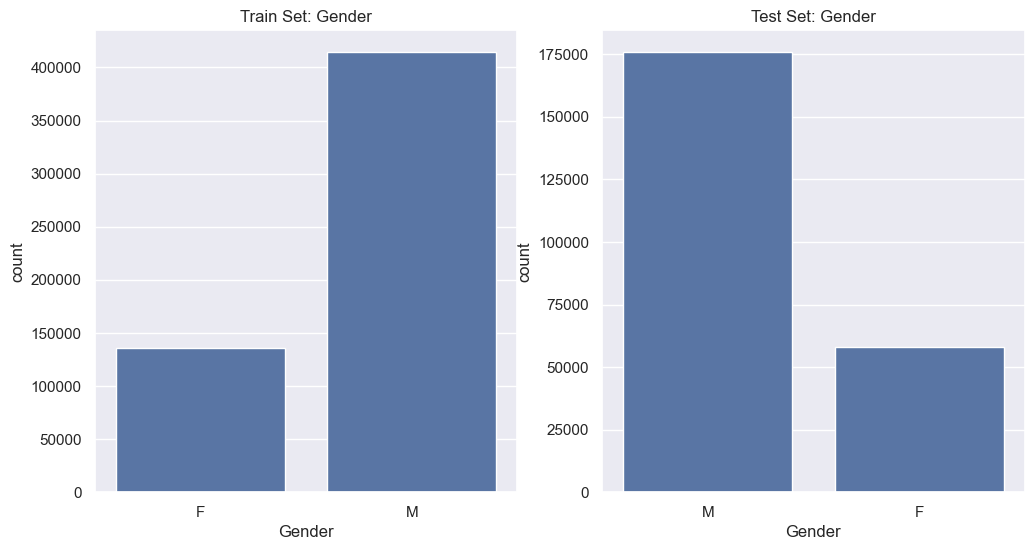

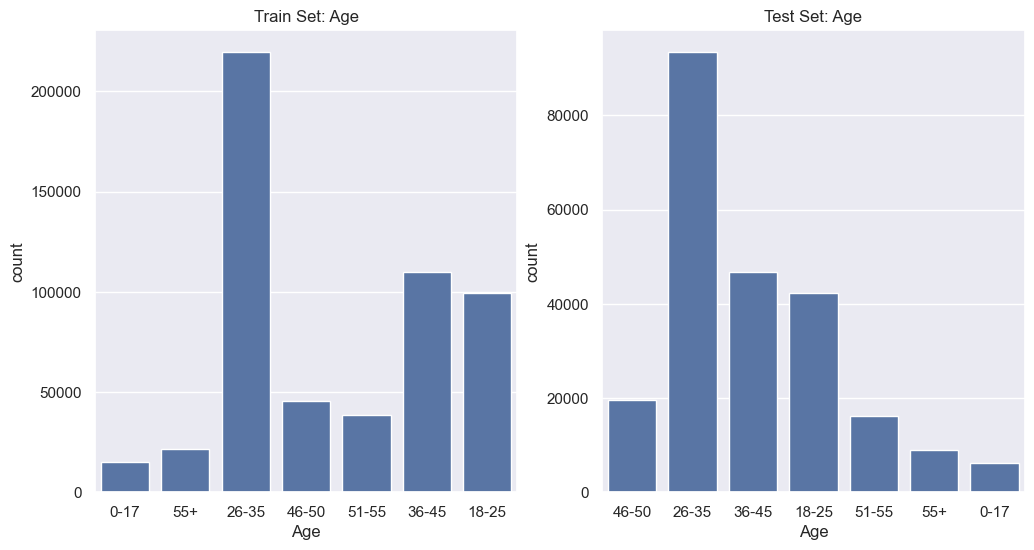

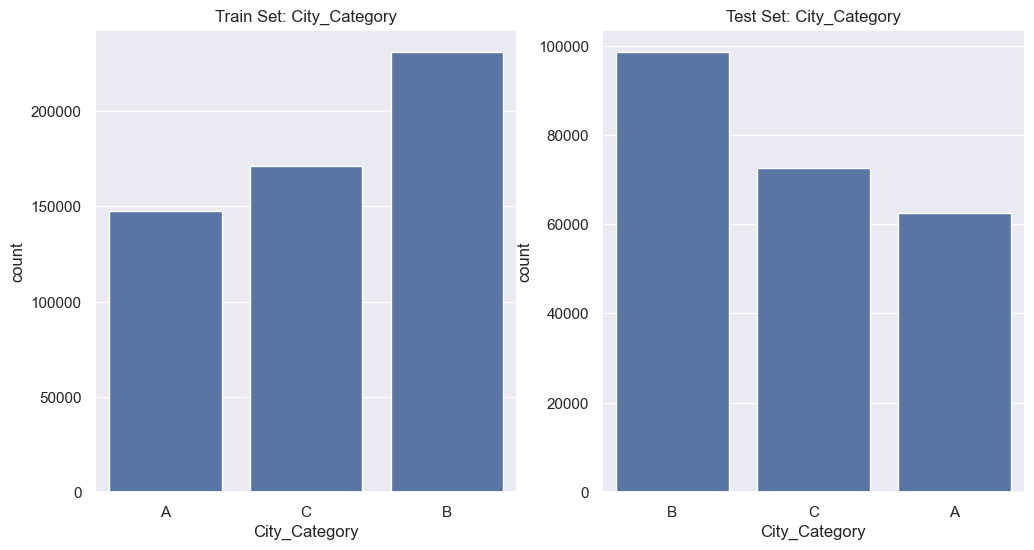

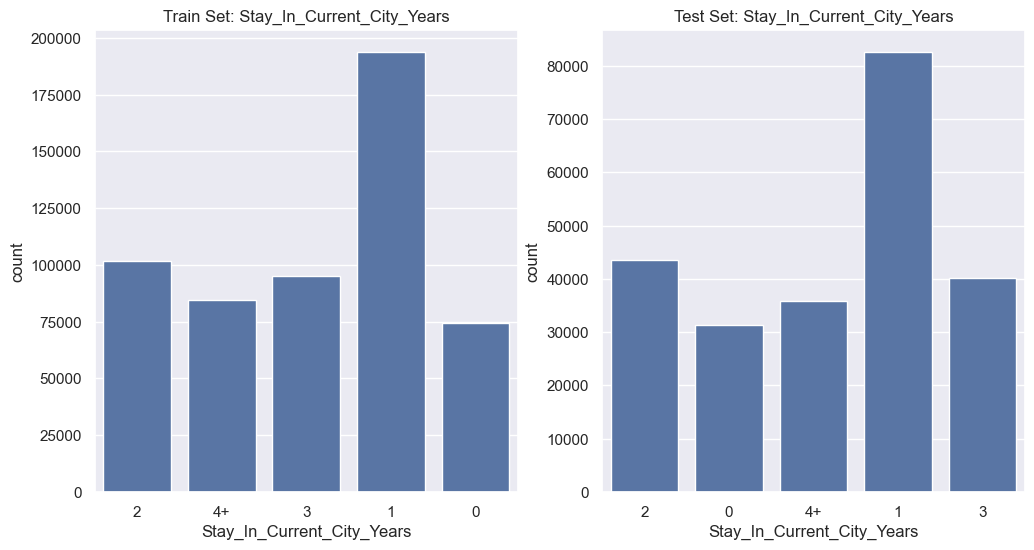

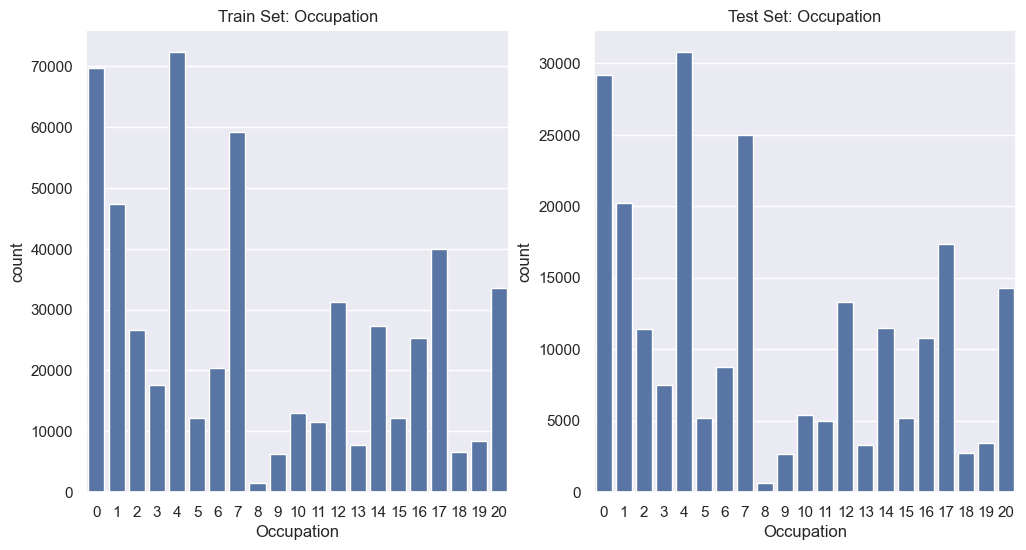

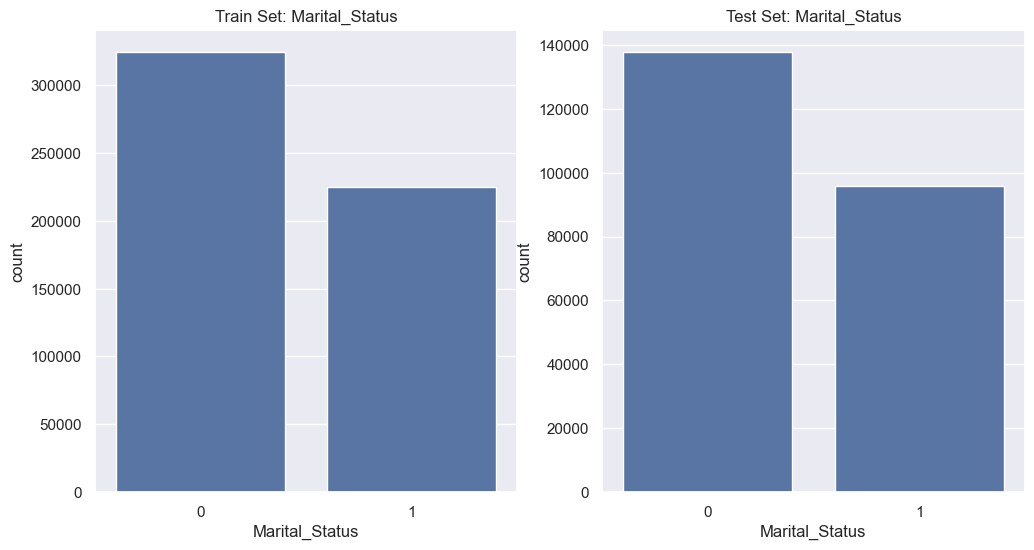

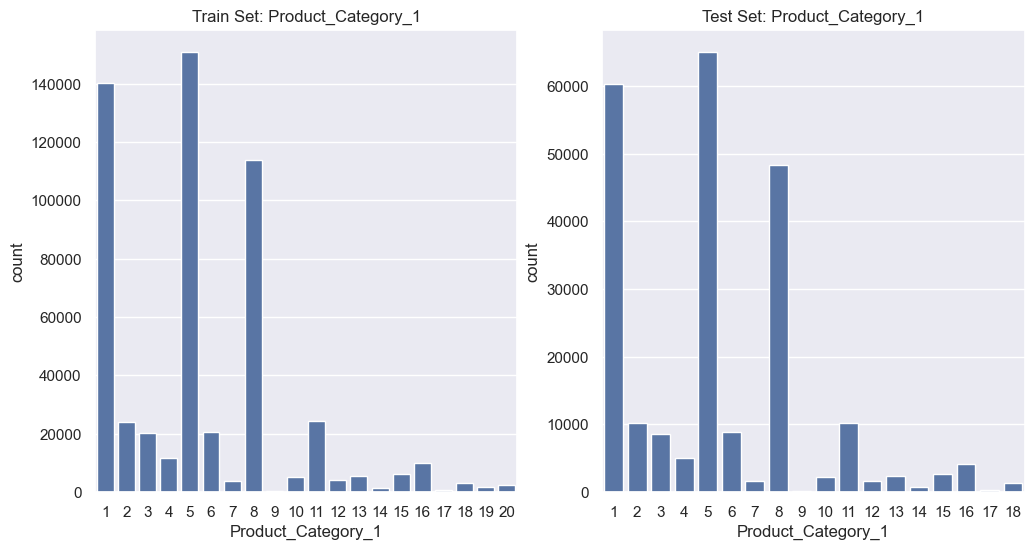

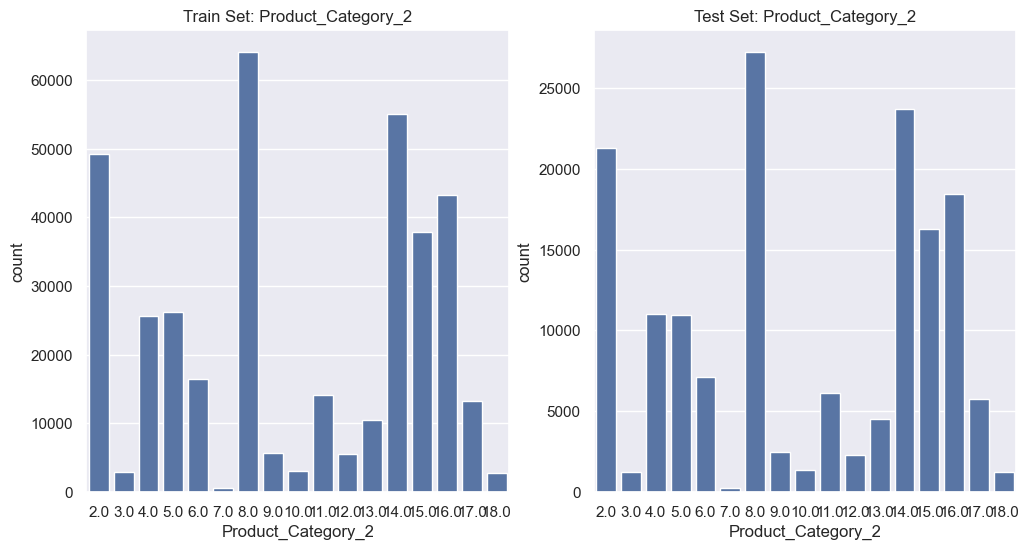

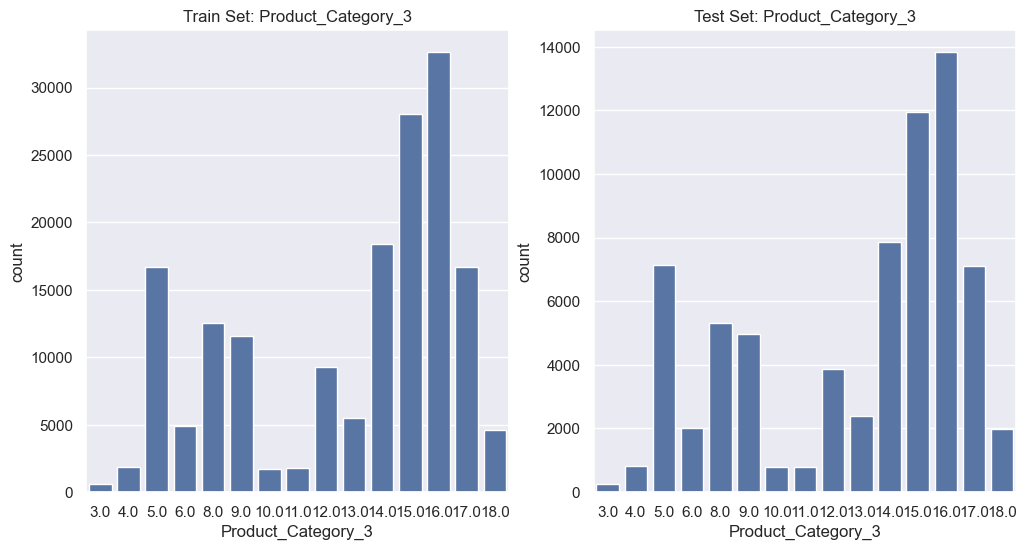

ValueError: Could not interpret value `NEW_Product_Category_1_Mean_Purchase` for `x`. An entry with this name does not appear in `data`.

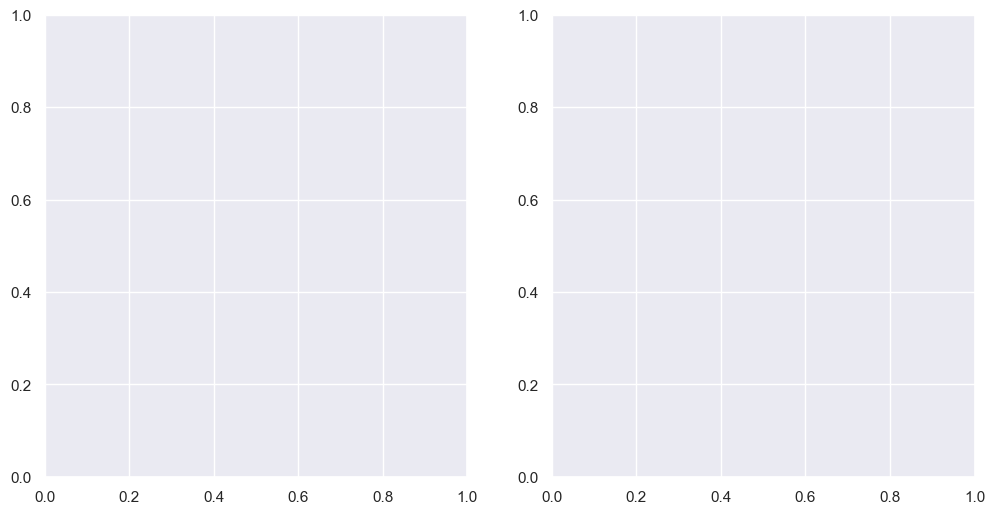

In [106]:
plot_categorical_comparison(df_train, df_test, cat_cols)

#### Observations
- Categorical variables of Train and test sets distributed almost identical

In [ ]:
for col in cat_cols:
    cat_summary(df_train_test, col, plot=True, target="Purchase", plot_type="all")

#### Observations
1. Gender
The dataset is significantly imbalanced in terms of gender, with male customers outnumbering female customers by approximately 3:1. On average, male customers spend 3.8% more than female customers. This suggests that gender may serve as a relevant predictor for the purchase amount.

2. Age
The age variable is provided in categorical form (e.g., 0–17, 18–25, ...). Although the distribution visually appears to resemble a normal distribution, this cannot be confirmed due to the categorical nature of the data. Mean purchase amounts are fairly consistent across all age groups, indicating that age might not be a strong individual predictor.

3. City_Category
The city category variable contains three groups: A, B, and C. The distribution among these categories is relatively balanced, with Category B being the most frequent, followed by C and A. Customers from City Category C spend approximately 3% more on average compared to those from categories A and B. This variable may offer useful insights when modeling purchase behavior.

4. Stay_In_Current_City_Years
The most frequent value in this category is 1 year, accounting for 35.2% of the data. Other categories are more evenly distributed. Mean purchase amounts are similar across all groups, suggesting this variable may have limited standalone predictive power but could still contribute in interaction with other variables.

5. Marital_Status
There is a slight imbalance between married and unmarried customers, with unmarried customers outnumbering married ones by 3:2. However, the average purchase amount is equally distributed (50:50) between the two groups. As such, marital status does not appear to influence purchase behavior significantly on its own.

6. Combinations of product categories have different impacts on purchase. Meaningfull features can be extracted from these combinations.

#### Numerical Columns Visualization

In [ ]:
for col in num_cols:
    num_summary_enhanced(df_train_test, col, plot=True, groupby=None, plot_type="all")

In [32]:
def kde_plot(data, col):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data[col], color='blue', label='Train', fill=True)
    plt.title(f'KDE Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

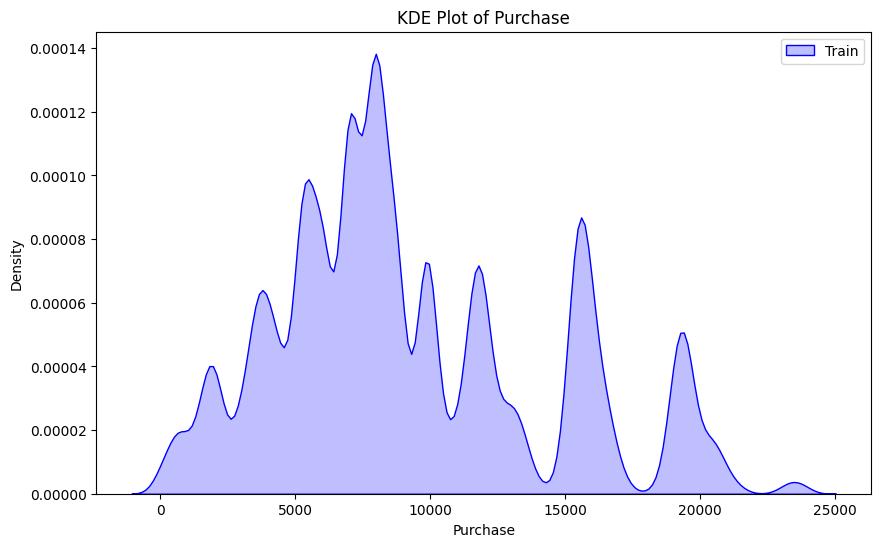

In [33]:
# kde plot of Purchase
kde_plot(df_train_test, 'Purchase')

#### Observations
-Local sparsities in Purchase distribution is the result of discrete products and combinations of product categories. Some combinations have lesser samples

#### Examination of Cardinal Feature

In [ ]:
df_train_test['Product_ID'].head(10)

In [ ]:
df_train_test[['Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']].head(20)

In [ ]:
df_train_test[['Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']].tail(20)

In [ ]:
print(df_train_test.shape)
# rows with Product_ID isnt starting with P
print("Rows with Product_ID not starting with P: ", df_train_test[~df_train_test['Product_ID'].str.startswith('P')].count())
# rows with Product_ID isnt ending with 42
print("\n\nRows with Product_ID not ending with 42: ", df_train_test[~df_train_test['Product_ID'].str.endswith('42')].count())
print("\n\nMean Purchase of Product_ID related to las to digits of Product_ID: ", df_train_test.groupby(df_train_test['Product_ID'].str[-2:])['Purchase'].mean().sort_values(ascending=False).head(10))

# last 2 characters of Product_ID
print("\n\nLast 2 characters of Product_ID: ", df_train_test['Product_ID'].str[-2:].value_counts())
# first 3 characters of Product_ID
print("\n\nFirst 3 characters of Product_ID: ", df_train_test['Product_ID'].str[:3].value_counts())
# first 4 characters of Product_ID
print("\n\nFirst 4 characters of Product_ID: ", df_train_test['Product_ID'].str[:4].value_counts())
# length of Product_ID
print("\n\nLength of Product_ID: ", df_train_test['Product_ID'].str.len().value_counts())

(783667, 11)
Rows with Product_ID not starting with P:  Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64


Rows with Product_ID not ending with 42:  Product_ID                    4153
Gender                        4153
Age                           4153
Occupation                    4153
City_Category                 4153
Stay_In_Current_City_Years    4153
Marital_Status                4153
Product_Category_1            4153
Product_Category_2            4153
Product_Category_3            4153
Purchase                      4153
dtype: int64


Mean Purchase of Product_ID related to las to digits of Product_ID:  Product_ID
42   9332.604
45    374.931
36    374.267
44    362.911

In [ ]:
# mean purchase of Product_ID length=9
print("\n\nMean Purchase of Product_ID length=9: ", df_train_test[df_train_test['Product_ID'].str.len() == 9]['Purchase'].mean())
# mean purchase of Product_ID length=8
print("\n\nMean Purchase of Product_ID length=8: ", df_train_test[df_train_test['Product_ID'].str.len() == 8]['Purchase'].mean())



Mean Purchase of Product_ID length=9:  9277.78284508147


Mean Purchase of Product_ID length=8:  8477.918421052631


In [10]:
# Product_ID frequency df
product_id_freq = df_train_test['Product_ID'].value_counts().reset_index()
product_id_freq.columns = ['Product_ID', 'Frequency']
product_id_freq.head()

,Product_ID,Frequency
0,P00265242,2709
1,P00025442,2310
2,P00110742,2292
3,P00112142,2279
4,P00046742,2084


In [11]:
product_purchase_sum = df_train_test.groupby('Product_ID')['Purchase'].sum().reset_index()
product_purchase_sum = product_purchase_sum.sort_values(by='Purchase', ascending=False)
product_purchase_sum.head()

,Product_ID,Purchase
251,P00025442,27995166.000
1036,P00110742,26722309.000
2475,P00255842,25168963.000
590,P00059442,24338343.000
1771,P00184942,24334887.000


In [12]:
# merging product_id_freq and product_purchase_sum
product_mean_purchase_freq = pd.merge(product_id_freq, product_purchase_sum, on='Product_ID')
product_mean_purchase_freq = product_mean_purchase_freq.sort_values(by='Purchase', ascending=False)
product_mean_purchase_freq.head(20)
# df of purchase null values ind product_id_freq
#product_mean_purchase_freq[product_mean_purchase_freq['Purchase'].isnull()].head()

,Product_ID,Frequency,Purchase
1,P00025442,2310,27995166.000
2,P00110742,2292,26722309.000
14,P00255842,1914,25168963.000
12,P00059442,1949,24338343.000
6,P00184942,2066,24334887.000
3,P00112142,2279,24216006.000
11,P00110942,1976,23639564.000
8,P00237542,1999,23425576.000
5,P00057642,2079,23102780.000
13,P00010742,1922,22164153.000


In [13]:
# removing 'P' from Product_ID
product_mean_purchase_freq['Product_ID'] = product_mean_purchase_freq['Product_ID'].str.replace('P', '', regex=False)

# extracting integers from Product_ID
product_mean_purchase_freq['Product_ID'] = product_mean_purchase_freq['Product_ID'].str.extract('(\d+)')

In [47]:
product_mean_purchase_freq.head()

,Product_ID,Frequency,Purchase
1,00025442,2310,27995166.000
2,00110742,2292,26722309.000
14,00255842,1914,25168963.000
12,00059442,1949,24338343.000
6,00184942,2066,24334887.000


In [14]:
product_mean_purchase_freq['Product_ID'].astype(int).describe().T

count     3677.000
mean    185367.336
std     107181.574
min        142.000
25%      92742.000
50%     185342.000
75%     277842.000
max     375436.000
Name: Product_ID, dtype: float64

In [15]:
product_mean_purchase_freq['Product_ID'].astype(int).astype(str).str.len().value_counts()
# Feature Engineering: Product_ID length

Product_ID
6    2685
5     893
4      90
3       9
Name: count, dtype: int64

In [16]:
product_mean_purchase_freq['Product_ID'].str[-2:].value_counts()
# Feature Engineering idea: Product_ID last 2 characters

Product_ID
42    3672
44       1
45       1
36       1
53       1
93       1
Name: count, dtype: int64

#### Product_ID Last Two Digits Based Feature

In [17]:
product_mean_purchase_freq['Last_Two_Digits'] = product_mean_purchase_freq['Product_ID'].str[-2:].astype(int)
product_mean_purchase_freq['Last_Two_Digits'].value_counts()

Last_Two_Digits
42    3672
44       1
45       1
36       1
53       1
93       1
Name: count, dtype: int64

In [18]:
last_two_freq = (
    product_mean_purchase_freq.groupby('Last_Two_Digits')
    .size()
    .reset_index(name='Frequency')
    .sort_values(by='Frequency', ascending=False)
)

In [19]:
last_two_freq.head()

,Last_Two_Digits,Frequency
1,42,3672
0,36,1
2,44,1
3,45,1
4,53,1


In [20]:
last2_purchase_means = (
    product_mean_purchase_freq
    .groupby('Last_Two_Digits')['Purchase']
    .mean()
    .sort_values()
)

In [21]:
last2_purchase_means.sort_values(ascending=False).head(10)

Last_Two_Digits
42   1387475.119
44    326257.000
45    313817.000
36    304653.000
53     30588.000
93     28790.000
Name: Purchase, dtype: float64

In [22]:
product_id_last2_label_map = {
    '42': 6,
    '44': 5,
    '45': 4,
    '36': 3,
    '53': 2,
    '93': 1,
}

#### Product_ID Length Based Feature

In [23]:
# product_id_lenght label map feature engineering
product_mean_purchase_freq['Product_ID_Length'] = product_mean_purchase_freq['Product_ID'].astype(int).astype(str).str.len()


In [24]:
product_mean_purchase_freq[['Purchase', 'Product_ID_Length']].head()

,Purchase,Product_ID_Length
1,27995166.000,5
2,26722309.000,6
14,25168963.000,6
12,24338343.000,5
6,24334887.000,6


In [25]:
# product id length mean purchase
product_id_length_means = (
    product_mean_purchase_freq
    .groupby('Product_ID_Length')['Purchase']
    .mean()
    .sort_values()
)

In [137]:
product_id_length_means.sort_values(ascending=False).head(10)

Product_ID_Length
3   3264490.444
4   1524664.611
6   1397917.907
5   1316688.614
Name: Purchase, dtype: float64

In [26]:
product_id_length_label_map = {
    3: 4,
    4: 3,
    6: 2,
    5: 1,
}

In [ ]:
#product_purchase_sum['Purchsae_Percent'] = product_purchase_sum['Purchase'] / df_train_test['Purchase'].sum() * 100
#product_purchase_sum = product_purchase_sum.reset_index(drop=True)
#product_purchase_sum.sort_values(by='Purchsae_Percent', ascending=False, inplace=True)
#print(df_train_test['Purchase'].sum())

5095812742.0


#### Strategy
- Product_ID is a cardinal feature. Model cant be based on product id no matter how related it is with purchase, But extracting impactfull features on purchase feature from Product_ID would do no harm.
- Product categories has to play a crucial role in generalizing the data. Frequent and valuable (threshold < mean Purchase) category number combinations will be turned into features and fed to the model.

### Feature Engineering

In [27]:
df_train_test['NEW_Category_Combo'] = list(zip(
    df_train_test['Product_Category_1'],
    df_train_test['Product_Category_2'],
    df_train_test['Product_Category_3']
))

In [28]:
combo_mean_purchase = df_train_test.groupby('NEW_Category_Combo')['Purchase'].mean().reset_index()
combo_mean_purchase.columns = ['Category_Combo', 'Combo_Mean_Purchase']

In [29]:
# sample count per category combo
combo_counts = df_train_test['NEW_Category_Combo'].value_counts().reset_index()
combo_counts.columns = ['Category_Combo', 'Count']

# Merging mean purchase and counts
combo_stats = combo_mean_purchase.merge(combo_counts, on='Category_Combo')


In [30]:
combo_stats['Count'].describe().T

count     237.000
mean     3306.612
std      9129.729
min         1.000
25%       399.000
50%      1093.000
75%      2439.000
max     91179.000
Name: Count, dtype: float64

In [31]:
combo_stats['Combo_Mean_Purchase'].describe().T

count     237.000
mean     9878.738
std      4709.040
min        37.042
25%      6399.331
50%     10441.069
75%     13430.779
max     20789.913
Name: Combo_Mean_Purchase, dtype: float64

In [32]:
# Implementing combo means into the main dataframe
df_train_test['NEW_Category_Combo_Mean_Purchase'] = df_train_test['NEW_Category_Combo'].map(
    combo_mean_purchase.set_index('Category_Combo')['Combo_Mean_Purchase']
)

In [33]:
selected_combos = combo_stats[
    (combo_stats['Count'] >= 399) & (combo_stats['Count'] <= 2439) &
    (combo_stats['Combo_Mean_Purchase'] >= 6399.331) & (combo_stats['Combo_Mean_Purchase'] <= 13430.779)
]['Category_Combo'].tolist()

In [34]:
len(selected_combos)

61

**Encoding Approach**
- One-Hot Encoding on selected_combos
- Ordinal Label Encoding on all category combos.

Two seperate models will be trained and will be compared

#### One-Hot Encoding on Selected Combos

In [97]:
# Implementing the selected combos into the main dataframe
df_train_test['NEW_Category_Combo'] = df_train_test['NEW_Category_Combo'].apply(
    lambda x: x if x in selected_combos else 'Other'
)

#### Ordinal Label Encoding All Category Combos

In [35]:
# Label encoding the NEW_Category_Combo based on their NEW_Category_Combo_Mean_Purchase
# Önce ortalamalara göre sıralıyoruz
combo_mean_sorted = (
    combo_mean_purchase
    .sort_values('Combo_Mean_Purchase')
    .reset_index(drop=True)
)

# Her bir Category_Combo için bir label veriyoruz
combo_mean_sorted['Category_Combo_Label'] = range(len(combo_mean_sorted))

# Şimdi df_train_test'e bu label'ları eşliyoruz
label_mapping = combo_mean_sorted.set_index('Category_Combo')['Category_Combo_Label']

# Mapping işlemi
df_train_test['NEW_Category_Combo_Label'] = df_train_test['NEW_Category_Combo'].map(label_mapping)

#### Adding Product Category Means as Feature

In [36]:
# Examining product category mean purchases

# Product_Category_1 için ortalama
category1_mean = df_train_test.groupby('Product_Category_1')['Purchase'].mean().reset_index()
category1_mean.columns = ['Product_Category_1', 'NEW_Product_Category_1_Mean_Purchase']

# Product_Category_2 için ortalama
category2_mean = df_train_test.groupby('Product_Category_2')['Purchase'].mean().reset_index()
category2_mean.columns = ['Product_Category_2', 'NEW_Product_Category_2_Mean_Purchase']

# Product_Category_3 için ortalama
category3_mean = df_train_test.groupby('Product_Category_3')['Purchase'].mean().reset_index()
category3_mean.columns = ['Product_Category_3', 'NEW_Product_Category_3_Mean_Purchase']


In [37]:
df_train_test = df_train_test.merge(category1_mean, on='Product_Category_1', how='left')
df_train_test = df_train_test.merge(category2_mean, on='Product_Category_2', how='left')
df_train_test = df_train_test.merge(category3_mean, on='Product_Category_3', how='left')


In [38]:
df_train_test.head()

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,NEW_Category_Combo,NEW_Category_Combo_Mean_Purchase,NEW_Category_Combo_Label,NEW_Product_Category_1_Mean_Purchase,NEW_Product_Category_2_Mean_Purchase,NEW_Product_Category_3_Mean_Purchase
0,P00069042,F,0-17,10,A,2,0,3,0,0,8370.000,"(3, 0, 0)",11782.485,140,10096.706,7518.695,8221.837
1,P00248942,F,0-17,10,A,2,0,1,6,14,15200.000,"(1, 6, 14)",15466.910,212,13606.219,11503.551,10052.595
2,P00087842,F,0-17,10,A,2,0,12,0,0,1422.000,"(12, 0, 0)",1331.960,8,1350.860,7518.695,8221.837
3,P00085442,F,0-17,10,A,2,0,12,14,0,1057.000,"(12, 14, 0)",1375.750,10,1350.860,7105.265,8221.837
4,P00285442,M,55+,16,C,4+,0,8,0,0,7969.000,"(8, 0, 0)",7514.934,86,7498.958,7518.695,8221.837


#### Feature Extraction from Cardinal Variable: Product_ID

In [39]:
# removing 'P' from Product_ID
df_train_test['Product_ID'] = df_train_test['Product_ID'].str.replace('P', '', regex=False)

# extracting integers from Product_ID
df_train_test['Product_ID'] = df_train_test['Product_ID'].str.extract('(\d+)').astype(int)

In [40]:
df_train_test['NEW_Product_ID_Length'] = df_train_test['Product_ID'].astype(str).str.len().astype(int).map(
    product_id_length_label_map
)
df_train_test['NEW_Product_ID_Last_Two_Digits'] = df_train_test['Product_ID'].astype(str).str[-2:].map(
    product_id_last2_label_map
)
df_train_test.head()

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,NEW_Category_Combo,NEW_Category_Combo_Mean_Purchase,NEW_Category_Combo_Label,NEW_Product_Category_1_Mean_Purchase,NEW_Product_Category_2_Mean_Purchase,NEW_Product_Category_3_Mean_Purchase,NEW_Product_ID_Length,NEW_Product_ID_Last_Two_Digits
0,69042,F,0-17,10,A,2,0,3,0,0,8370.000,"(3, 0, 0)",11782.485,140,10096.706,7518.695,8221.837,1,6
1,248942,F,0-17,10,A,2,0,1,6,14,15200.000,"(1, 6, 14)",15466.910,212,13606.219,11503.551,10052.595,2,6
2,87842,F,0-17,10,A,2,0,12,0,0,1422.000,"(12, 0, 0)",1331.960,8,1350.860,7518.695,8221.837,1,6
3,85442,F,0-17,10,A,2,0,12,14,0,1057.000,"(12, 14, 0)",1375.750,10,1350.860,7105.265,8221.837,1,6
4,285442,M,55+,16,C,4+,0,8,0,0,7969.000,"(8, 0, 0)",7514.934,86,7498.958,7518.695,8221.837,2,6


In [41]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train_test)
print(f"Categorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")
print(f"Categorical but Cardinal Columns: {cat_but_car}")

Observations: 783667
Variables: 19
cat_cols: 14
num_cols: 4
cat_but_car: 1
num_but_cat: 10
Categorical Columns: ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Occupation', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'NEW_Product_Category_1_Mean_Purchase', 'NEW_Product_Category_2_Mean_Purchase', 'NEW_Product_Category_3_Mean_Purchase', 'NEW_Product_ID_Length', 'NEW_Product_ID_Last_Two_Digits']
Numerical Columns: ['Product_ID', 'Purchase', 'NEW_Category_Combo_Mean_Purchase', 'NEW_Category_Combo_Label']
Categorical but Cardinal Columns: ['NEW_Category_Combo']


In [42]:
columns_to_drop = ['NEW_Category_Combo', 'Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']

In [43]:
df_train_test.drop(columns=columns_to_drop, inplace=True)

In [44]:
columns_to_encode = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Occupation', 'Marital_Status']

In [45]:
df_train_test = one_hot_encoder(
    df_train_test,
    categorical_cols=columns_to_encode,
    drop_first=True
)

In [46]:
df_train_test.head()

,Purchase,NEW_Category_Combo_Mean_Purchase,NEW_Category_Combo_Label,NEW_Product_Category_1_Mean_Purchase,NEW_Product_Category_2_Mean_Purchase,NEW_Product_Category_3_Mean_Purchase,NEW_Product_ID_Length,NEW_Product_ID_Last_Two_Digits,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,Occupation_10,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,Marital_Status_1
0,8370.000,11782.485,140,10096.706,7518.695,8221.837,1,6,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,15200.000,15466.910,212,13606.219,11503.551,10052.595,2,6,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,1422.000,1331.960,8,1350.860,7518.695,8221.837,1,6,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,1057.000,1375.750,10,1350.860,7105.265,8221.837,1,6,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,7969.000,7514.934,86,7498.958,7518.695,8221.837,2,6,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [47]:
# Labeling bool columns
bool_cols = df_train_test.select_dtypes(include=['bool']).columns.tolist()
for col in bool_cols:
    df_train_test[col] = df_train_test[col].astype(int)

In [48]:
df_train_test.head()

,Purchase,NEW_Category_Combo_Mean_Purchase,NEW_Category_Combo_Label,NEW_Product_Category_1_Mean_Purchase,NEW_Product_Category_2_Mean_Purchase,NEW_Product_Category_3_Mean_Purchase,NEW_Product_ID_Length,NEW_Product_ID_Last_Two_Digits,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,Occupation_10,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,Marital_Status_1
0,8370.000,11782.485,140,10096.706,7518.695,8221.837,1,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,15200.000,15466.910,212,13606.219,11503.551,10052.595,2,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1422.000,1331.960,8,1350.860,7518.695,8221.837,1,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1057.000,1375.750,10,1350.860,7105.265,8221.837,1,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,7969.000,7514.934,86,7498.958,7518.695,8221.837,2,6,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Feature Importance Examination

In [99]:
# Splitting the data back into train and test sets
df_train_preprocessed = df_train_test[df_train_test['Purchase'].notna()]
df_test_preprocessed = df_train_test[df_train_test['Purchase'].isna()]
df_test_preprocessed.drop(columns=['Purchase'], inplace=True)

C:\Users\borab\AppData\Local\Temp\ipykernel_27060\3014367108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_preprocessed.drop(columns=['Purchase'], inplace=True)


In [100]:
# Training a simple tree-based model
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = df_train_preprocessed.drop(['Purchase'], axis=1)
y = df_train_preprocessed['Purchase']
X = pd.DataFrame(scaler.fit_transform(X), columns=df_train_test.columns.drop('Purchase'))
X_test = pd.DataFrame(scaler.transform(df_test_preprocessed), columns=df_test_preprocessed.columns)

In [102]:
rfmodel = RandomForestRegressor(random_state=42, n_jobs=-1)
rfmodel.fit(X, y)

RandomForestRegressor(n_jobs=-1, random_state=42)

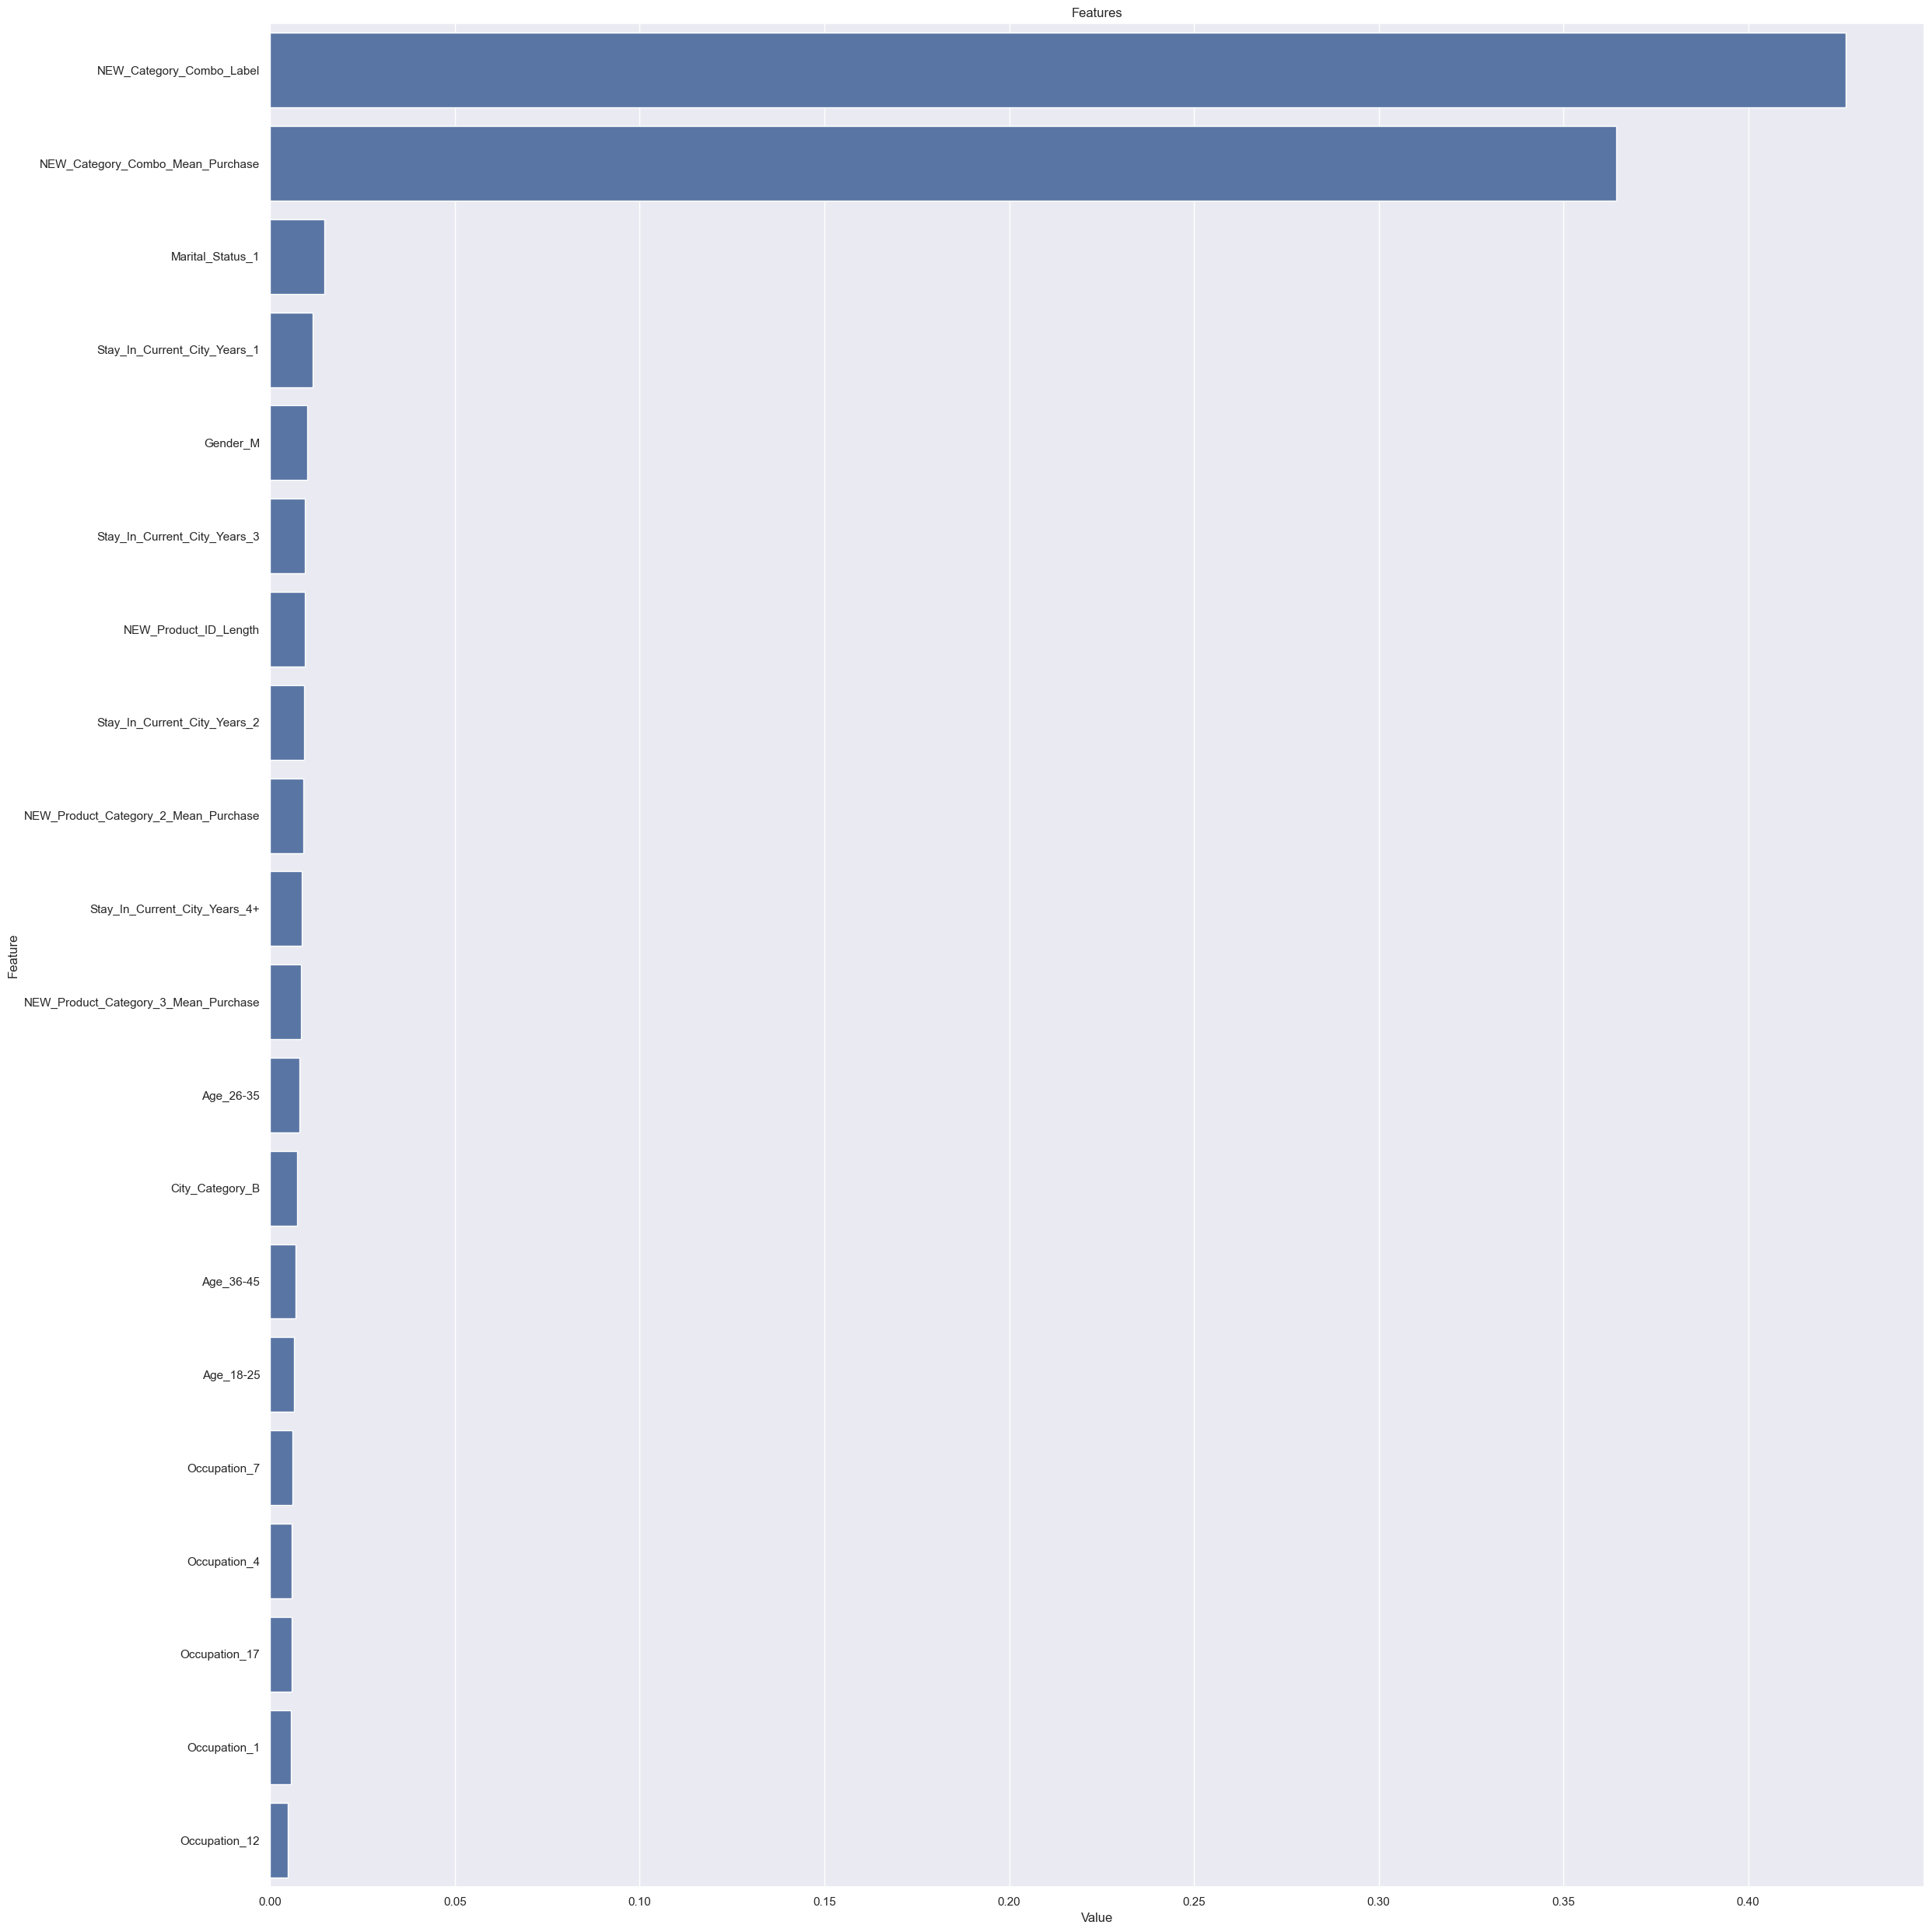

,Value,Feature
0,0.364,NEW_Category_Combo_Mean_Purchase
1,0.426,NEW_Category_Combo_Label
2,0.004,NEW_Product_Category_1_Mean_Purchase
3,0.009,NEW_Product_Category_2_Mean_Purchase
4,0.008,NEW_Product_Category_3_Mean_Purchase
5,0.009,NEW_Product_ID_Length
6,0.000,NEW_Product_ID_Last_Two_Digits
7,0.010,Gender_M
8,0.006,Age_18-25
9,0.008,Age_26-35


In [108]:
plot_importance(rfmodel, X, num=20)

## Model Training